In [1]:
import os
from os.path import join

import numpy as np
import pandas as pd
import cv2
import seaborn as sns

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tqdm import tqdm

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_pickle("/content/drive/Shareddrives/TNT/정규세션/2022년 1학기/산업 인공지능/TASK2-wafer map /LSWMD.pkl")

Mounted at /content/drive


# TrainTestLabel 이름변경

In [4]:
df.rename(columns = {'trianTestLabel':'TrainTestLabel'}, inplace = 'True')

print('[[Training]] dimension : ', df.TrainTestLabel[0].shape, '[] dimension : ', df.TrainTestLabel[52166].shape)

[[Training]] dimension :  (1, 1) [] dimension :  (0, 0)


In [5]:
def removebrackets(array):
    if array.shape == (1, 1):
        return "".join(array[0])
    elif array.shape == (0, 0):
        return None
        
df['TrainTestLabel'] = df['TrainTestLabel'].apply(removebrackets)
df['failureType'] = df['failureType'].apply(removebrackets)
df.sample(20)

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
300861,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4096.0,lot18437,10.0,None,None
595912,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot37334,9.0,None,None
496445,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot30805,20.0,None,None
500318,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,...",710.0,lot31121,12.0,None,None
464666,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot28583,1.0,None,None
251361,"[[0, 0, 0, 0, 0, 0, 2, 1, 2, 2, 1, 2, 2, 0, 0,...",260.0,lot15607,21.0,None,None
676042,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",592.0,lot42050,24.0,Test,none
739007,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1507.0,lot44602,11.0,Test,Loc
91920,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot6550,7.0,None,None
778007,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1414.0,lot46184,24.0,Test,none


# TrainTestLabel - None
# failureType -None 
## -> 두 조합의 결측치 갯수 : 638507
# none -> 정상
# 정상 데이터 -> Normal로 표기
# 1만개 샘플링

In [6]:
df.failureType.value_counts()

none         147431
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-full       149
Name: failureType, dtype: int64

In [7]:
sum = 0

for idx in range(df.failureType.value_counts().shape[0]):
  temp = df.failureType.value_counts()[idx]
  sum = sum+ temp

print(df.shape[0]- sum)

638507


In [8]:
# None 값 카운트
df.isna().sum()

waferMap               0
dieSize                0
lotName                0
waferIndex             0
TrainTestLabel    638507
failureType       638507
dtype: int64

In [9]:
df = df.dropna(axis = 0)
df = df.reset_index().iloc[:,1:]
df

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none
...,...,...,...,...,...,...
172945,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc
172946,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc
172947,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring
172948,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc


In [10]:
df.failureType.value_counts()

none         147431
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-full       149
Name: failureType, dtype: int64

In [11]:
df.TrainTestLabel.value_counts()

Test        118595
Training     54355
Name: TrainTestLabel, dtype: int64

# none 147431개 -> Normal 표기 및 1만개 샘플링

In [13]:
from sklearn.impute import SimpleImputer
target = df.failureType
imputer = SimpleImputer(missing_values = target.iloc[0],strategy= 'constant', fill_value= 1)
temp = np.array(target).reshape(-1,1)
imputer.fit(temp)
imputed_df_failureType= imputer.transform(temp)

imputed_df_failureType = pd.DataFrame(imputed_df_failureType)

# imputer = SimpleImputer(missing_values = imputed_df_failureType.iloc[-1][0],strategy= 'constant', fill_value= 1)
# temp = np.array(imputed_df_failureType).reshape(-1,1)
# imputer.fit(temp)
# imputed_df_failureType= imputer.transform(temp)
# imputed_df_failureType

In [14]:
pd.DataFrame(imputed_df_failureType).value_counts()

1            147431
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-full       149
dtype: int64

In [15]:
df.failureType = pd.DataFrame(imputed_df_failureType)
df

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,1
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,1
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,1
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,1
...,...,...,...,...,...,...
172945,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc
172946,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc
172947,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring
172948,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc


In [16]:
ref = df['TrainTestLabel']
comp = df['failureType']
count = 0
upto = 10000

for idx in tqdm(range(df.shape[0])):

  if count == upto:
    break

  # temp_ref_value = ref[idx]
  temp_comp_value = comp[idx]

  if temp_comp_value == 1:

    # if temp_ref_value == temp_comp_value:
    #   df['TrainTestLabel'][idx] = 'Training'
    df['failureType'][idx] = 'Normal'
    count = count +1
  


df
print(count)

  0%|          | 0/172950 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 11%|█         | 18249/172950 [00:13<01:53, 1359.20it/s]

10000


In [17]:
df.failureType.value_counts()

1            137431
Normal        10000
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-full       149
Name: failureType, dtype: int64

In [18]:
df = df.reset_index().iloc[:,1:]
df

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,Normal
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,Normal
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,Normal
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,Normal
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,Normal
...,...,...,...,...,...,...
172945,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc
172946,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc
172947,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring
172948,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc


In [19]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values = 1,strategy= 'constant', fill_value= np.nan)
temp = np.array(df.failureType).reshape(-1,1)
imputer.fit(temp)
imputed_df_failureType= imputer.transform(temp)
imputed_df_failureType

array([['Normal'],
       ['Normal'],
       ['Normal'],
       ...,
       ['Edge-Ring'],
       ['Edge-Loc'],
       ['Edge-Ring']], dtype=object)

In [20]:
pd.DataFrame(imputed_df_failureType).value_counts()

Normal       10000
Edge-Ring     9680
Edge-Loc      5189
Center        4294
Loc           3593
Scratch       1193
Random         866
Donut          555
Near-full      149
dtype: int64

In [21]:
df.failureType = pd.DataFrame(imputed_df_failureType)
df

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,Normal
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,Normal
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,Normal
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,Normal
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,Normal
...,...,...,...,...,...,...
172945,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc
172946,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc
172947,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring
172948,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc


In [22]:
df = df.dropna(axis = 0).reset_index().iloc[:,1:]
df

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,Normal
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,Normal
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,Normal
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,Normal
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,Normal
...,...,...,...,...,...,...
35514,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc
35515,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc
35516,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring
35517,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc


In [23]:
df.failureType.value_counts()

Normal       10000
Edge-Ring     9680
Edge-Loc      5189
Center        4294
Loc           3593
Scratch       1193
Random         866
Donut          555
Near-full      149
Name: failureType, dtype: int64

# 무시

In [15]:
# df.failureType에 1을 가지는 인덱스 추출

# index = np.where(df.failureType == df.failureType.iloc[0])[0]
index = np.where(df.failureType == 1)[0]
print('Index.shape = ', index.shape)

# 혹시 시간과 관련 부분 및 다양성을 위한 shuffle
np.random.shuffle(index)

# moving average와 같은 다운 샘플링 기법은 나중에 모델 고도화 할 때, 평가
# 10,000개만 샘플링
target_index = index[:10000]

temp = df.failureType

for idx in tqdm(target_index):
  temp[idx] = 'Normal'

temp.value_counts()


Index.shape =  (147431,)


  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 10000/10000 [00:11<00:00, 879.88it/s]


1            137431
Normal        10000
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-full       149
Name: failureType, dtype: int64

In [16]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values = 1,strategy= 'constant', fill_value= np.nan)
temp_temp = np.array(temp).reshape(-1,1)
imputer.fit(temp_temp)
imputed_df_temp= imputer.transform(temp_temp)
imputed_df_temp

array([[nan],
       [nan],
       [nan],
       ...,
       ['Edge-Ring'],
       ['Edge-Loc'],
       ['Edge-Ring']], dtype=object)

In [17]:
df.failureType = pd.DataFrame(imputed_df_temp)
df

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,NaN
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,NaN
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,NaN
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,NaN
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,NaN
...,...,...,...,...,...,...
172945,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc
172946,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc
172947,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring
172948,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc


In [18]:
final_df = df.dropna(axis = 0)
final_df.failureType.value_counts()

Normal       10000
Edge-Ring     9680
Edge-Loc      5189
Center        4294
Loc           3593
Scratch       1193
Random         866
Donut          555
Near-full      149
Name: failureType, dtype: int64

In [19]:
final_df.sample(20)

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
24016,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",1075.0,lot23106,4.0,Training,Edge-Ring
59472,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1233.0,lot42609,15.0,Test,Normal
135391,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1334.0,lot45960,6.0,Test,Normal
80349,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",516.0,lot43533,10.0,Test,Near-full
36300,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot40758,20.0,Test,Normal
129815,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1376.0,lot45724,3.0,Test,Normal
27887,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",515.0,lot39532,8.0,Training,Center
60879,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1129.0,lot42673,24.0,Test,Normal
7469,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",1075.0,lot2499,12.0,Training,Edge-Ring
7768,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",1075.0,lot2511,23.0,Training,Edge-Ring


# 다시

In [24]:
final_df = df
final_df

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,Normal
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,Normal
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,Normal
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,Normal
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,Normal
...,...,...,...,...,...,...
35514,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc
35515,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc
35516,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring
35517,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc


값 : [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25.] 
 빈도 : [1455 1385 1417 1365 1419 1435 1417 1396 1351 1421 1405 1464 1436 1419
 1455 1431 1418 1416 1380 1412 1426 1469 1417 1442 1468]


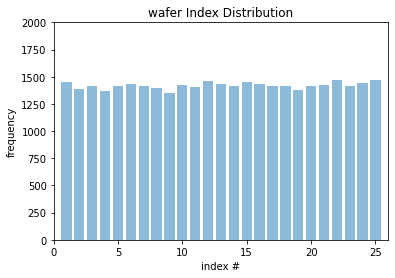

In [25]:
import matplotlib.pyplot as plt

uni_index = np.unique(final_df.waferIndex, return_counts = True)
print('값 :', uni_index[0],'\n','빈도 :',uni_index[1])
plt.bar(uni_index[0], uni_index[1], align ='center', alpha = 0.5)
plt.title("wafer Index Distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(0, 2000)
plt.show()

In [26]:
def find_dim(x):
  temp_dim1 = np.size(x, axis = 0)
  temp_dim2 = np.size(x, axis = 0)
  return temp_dim1, temp_dim2

final_df['waferMapDIm'] = final_df.waferMap.apply(find_dim)
final_df.head()

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType,waferMapDIm
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,Normal,"(45, 45)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,Normal,"(45, 45)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,Normal,"(45, 45)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,Normal,"(45, 45)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,Normal,"(45, 45)"


In [27]:
temp = pd.DataFrame(final_df.groupby('waferMapDIm').size().sort_values(ascending=False)[:], index = None)
N = temp.iloc[:,0].sum()

In [28]:
temp

,0
waferMapDIm,
"(26, 26)",7470
"(25, 25)",3252
"(38, 38)",2663
"(53, 53)",1757
"(41, 41)",1714
...,...
"(126, 126)",2
"(94, 94)",2
"(153, 153)",2


In [29]:
list = []
kiki = 0
for idx in range(temp.shape[0]):
  temp_value = temp.iloc[idx ,0]
  weight = temp_value / N
  list.append(np.array(temp.index[idx][0]) * weight)

weightAvg  = round(np.array(list).sum())

print('가중 평균 : ', weightAvg)

가중 평균 :  41


In [30]:
temp_waferMap = np.array(final_df['waferMap'])
temp_label = np.array(final_df.iloc[:,4:-1])
final_info_ness = np.c_[temp_waferMap, temp_label]
final_info_ness = pd.DataFrame(final_info_ness)
final_info_ness.columns = ['waferMap', 'TrainTest', 'Label']
final_info_ness

,waferMap,TrainTest,Label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,Normal
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,Normal
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,Normal
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,Normal
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,Normal
...,...,...,...
35514,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",Test,Edge-Loc
35515,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",Test,Edge-Loc
35516,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",Test,Edge-Ring
35517,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",Test,Edge-Loc


In [31]:
print(final_info_ness.TrainTest.value_counts())

Training    27625
Test         7894
Name: TrainTest, dtype: int64


In [32]:
final_info_ness.Label.value_counts()

Normal       10000
Edge-Ring     9680
Edge-Loc      5189
Center        4294
Loc           3593
Scratch       1193
Random         866
Donut          555
Near-full      149
Name: Label, dtype: int64

In [33]:
temp = final_info_ness.loc[final_info_ness.TrainTest == 'Training']
# Training 정보 가지고 있는 애들 모여랏
final_info_train = temp
print('Number of train data : ', final_info_train.shape[0])
final_info_train.Label.value_counts()/final_info_train.shape[0] *100

Number of train data :  27625


Normal       36.199095
Edge-Ring    30.964706
Center       12.532127
Edge-Loc      8.749321
Loc           5.864253
Random        2.204525
Scratch       1.809955
Donut         1.480543
Near-full     0.195475
Name: Label, dtype: float64

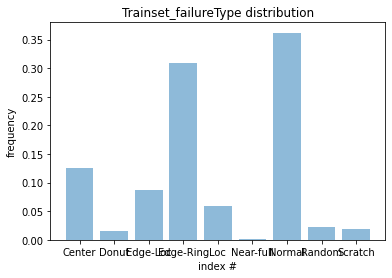

In [34]:
uni_Index=np.unique(final_info_train.Label, return_counts=True)
plt.bar(uni_Index[0], uni_Index[1]/final_info_train.Label.shape[0], align='center', alpha=0.5)
plt.title("Trainset_failureType distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.show()

In [35]:
temp = final_info_ness.loc[final_info_ness.TrainTest == 'Test']
final_info_ness_test = temp

print('Number of train data : ', final_info_ness_test.shape[0])
final_info_ness_test.Label.value_counts()/final_info_ness_test.shape[0] *100

Number of train data :  7894


Edge-Loc     35.115277
Loc          24.993666
Edge-Ring    14.263998
Center       10.539650
Scratch       8.778819
Random        3.255637
Donut         1.849506
Near-full     1.203446
Name: Label, dtype: float64

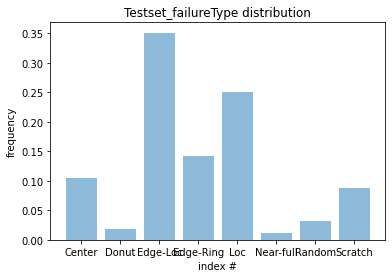

In [36]:
uni_Index=np.unique(final_info_ness_test.Label, return_counts=True)
plt.bar(uni_Index[0], uni_Index[1]/final_info_ness_test.shape[0], align='center', alpha=0.5)
plt.title("Testset_failureType distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.show()

In [37]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(final_info_ness, test_size =  0.3 ,stratify = final_info_ness.Label, shuffle = True)
trainset = trainset.reset_index()
testset = testset.reset_index()

In [38]:
trainset

,index,waferMap,TrainTest,Label
0,16258,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,Normal
1,12669,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,Edge-Ring
2,30360,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1,...",Test,Scratch
3,8988,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",Training,Loc
4,10777,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,...",Training,Center
...,...,...,...,...
24858,2718,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1,...",Training,Normal
24859,4111,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",Training,Normal
24860,4435,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1,...",Training,Normal
24861,4761,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",Training,Normal


In [39]:
testset

,index,waferMap,TrainTest,Label
0,24293,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1,...",Training,Center
1,4513,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1,...",Training,Normal
2,23251,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,Center
3,1254,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",Training,Normal
4,12179,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,Edge-Ring
...,...,...,...,...
10651,368,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",Training,Normal
10652,23757,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,Edge-Loc
10653,11870,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...",Training,Center
10654,18266,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,Donut


In [40]:
for idx in tqdm(range(testset.shape[0])):
  temp = testset.TrainTest[idx]
  if temp == 'Training':
    testset.TrainTest[idx] = 'Test'
testset

  0%|          | 0/10656 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
100%|██████████| 10656/10656 [00:05<00:00, 1919.97it/s]


,index,waferMap,TrainTest,Label
0,24293,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1,...",Test,Center
1,4513,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1,...",Test,Normal
2,23251,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Test,Center
3,1254,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",Test,Normal
4,12179,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Test,Edge-Ring
...,...,...,...,...
10651,368,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",Test,Normal
10652,23757,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Test,Edge-Loc
10653,11870,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...",Test,Center
10654,18266,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Test,Donut


In [41]:
for idx in tqdm(range(trainset.shape[0])):
  temp = trainset.TrainTest[idx]
  if temp == 'Test':
    trainset.TrainTest[idx] = 'Training'
trainset

  0%|          | 0/24863 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
100%|██████████| 24863/24863 [00:04<00:00, 5339.09it/s]


,index,waferMap,TrainTest,Label
0,16258,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,Normal
1,12669,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,Edge-Ring
2,30360,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1,...",Training,Scratch
3,8988,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",Training,Loc
4,10777,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,...",Training,Center
...,...,...,...,...
24858,2718,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1,...",Training,Normal
24859,4111,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",Training,Normal
24860,4435,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1,...",Training,Normal
24861,4761,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",Training,Normal


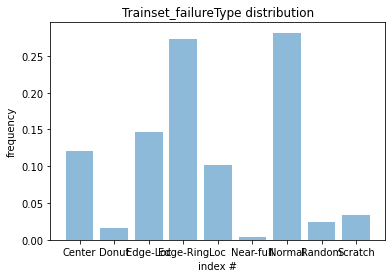

In [42]:
uni_Index=np.unique(trainset.Label, return_counts=True)
plt.bar(uni_Index[0], uni_Index[1]/trainset.Label.shape[0], align='center', alpha=0.5)
plt.title("Trainset_failureType distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.show()

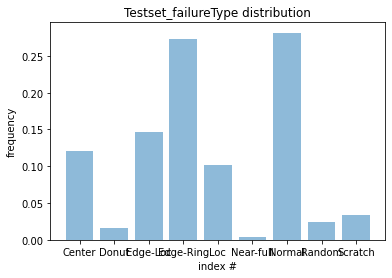

In [43]:
uni_Index=np.unique(testset.Label, return_counts=True)
plt.bar(uni_Index[0], uni_Index[1]/testset.shape[0], align='center', alpha=0.5)
plt.title("Testset_failureType distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.show()

# onehotencoding

In [40]:
# train test split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# encoder = LabelEncoder()
# encoded_labels = encoder.fit_transform(labels)
# x_train, x_test, y_train, y_test = train_test_split(new_x, encoded_labels, test_size=0.2, shuffle=True, stratify=encoded_labels, random_state=42)
# unaugmented_x_train = x_train
# unaugmented_y_train = y_train

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
onehot_encoder = preprocessing.OneHotEncoder()
train_y = label_encoder.fit_transform(trainset['Label'])
train_y_reshape = train_y.reshape(-1,1)
train_y_onehot = onehot_encoder.fit_transform(train_y_reshape)
train_y_onehot_ary = train_y_onehot.toarray()

In [240]:
pd.DataFrame(train_y).value_counts()

6    5636
3    5456
2    2925
0    2420
4    2025
8     673
7     488
1     313
5      84
dtype: int64

In [238]:
print(pd.DataFrame(train_y_onehot_ary).value_counts())

0    1    2    3    4    5    6    7    8  
0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0    5636
               1.0  0.0  0.0  0.0  0.0  0.0    5456
          1.0  0.0  0.0  0.0  0.0  0.0  0.0    2925
1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    2420
0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0    2025
                    0.0  0.0  0.0  0.0  1.0     673
                                   1.0  0.0     488
     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     313
     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      84
dtype: int64


In [215]:
trainset.Label.value_counts()


Normal       5636
Edge-Ring    5456
Edge-Loc     2925
Center       2420
Loc          2025
Scratch       673
Random        488
Donut         313
Near-full      84
Name: Label, dtype: int64

In [41]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
onehot_encoder = preprocessing.OneHotEncoder()
test_y = label_encoder.fit_transform(testset['Label'])
test_y_reshape = test_y.reshape(-1,1)
test_y_onehot = onehot_encoder.fit_transform(test_y_reshape)
test_y_onehot = test_y_onehot.toarray()

In [242]:
pd.DataFrame(test_y).value_counts()

6    4364
3    4224
2    2264
0    1874
4    1568
8     520
7     378
1     242
5      65
dtype: int64

In [244]:
pd.DataFrame(testset.Label).value_counts()

Label    
Normal       4364
Edge-Ring    4224
Edge-Loc     2264
Center       1874
Loc          1568
Scratch       520
Random        378
Donut         242
Near-full      65
dtype: int64

In [245]:
pd.DataFrame(test_y_onehot).value_counts()

0    1    2    3    4    5    6    7    8  
0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0    4364
               1.0  0.0  0.0  0.0  0.0  0.0    4224
          1.0  0.0  0.0  0.0  0.0  0.0  0.0    2264
1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    1874
0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0    1568
                    0.0  0.0  0.0  0.0  1.0     520
                                   1.0  0.0     378
     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     242
     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      65
dtype: int64

# 이미지 확인

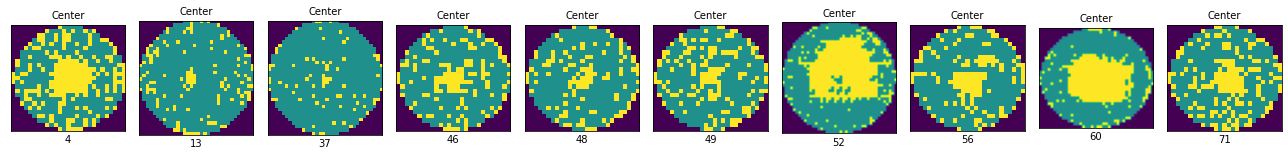

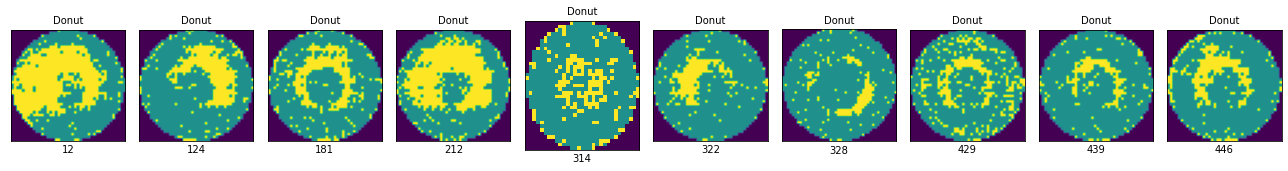

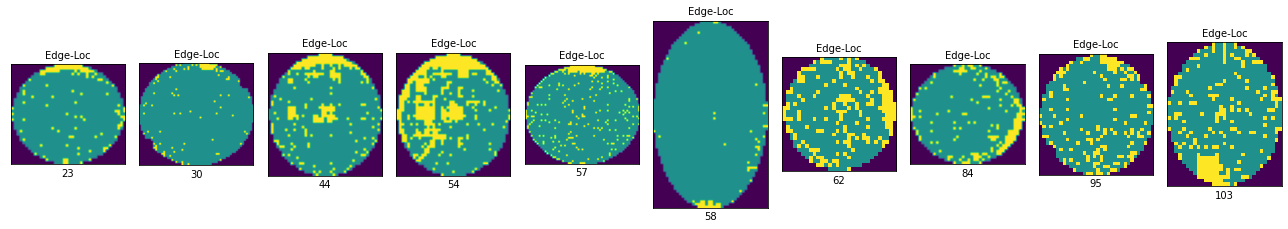

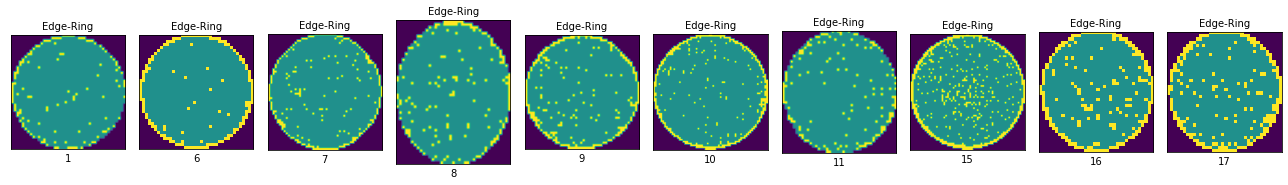

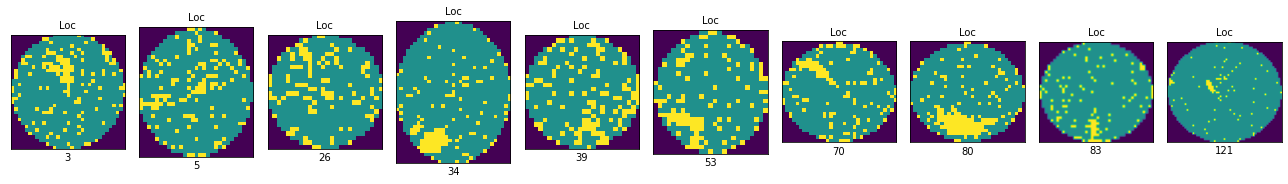

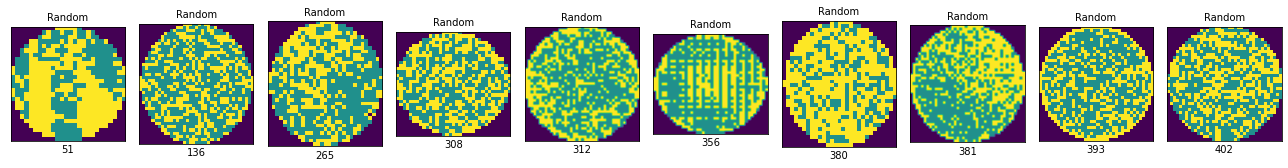

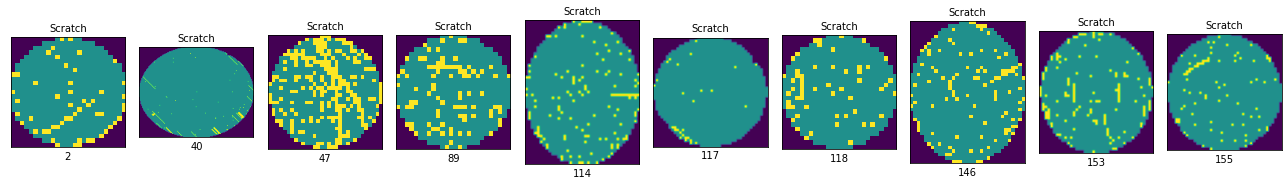

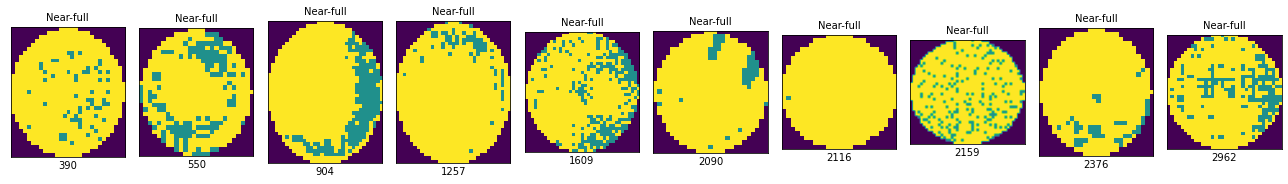

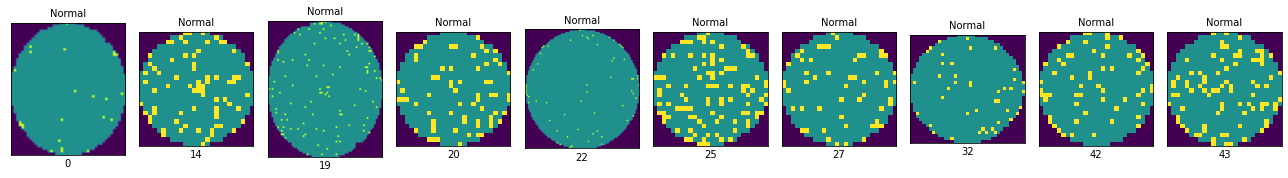

In [44]:
x = [0,1,2,3,4,5,6,7,8]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','Normal']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = trainset.waferMap[trainset.Label==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(trainset.Label[img.index[i]], fontsize=10)
            ax[i].set_xlabel(trainset.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

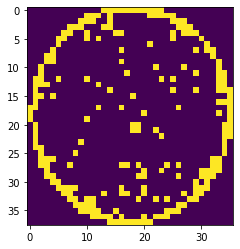

In [45]:
import cv2
img = trainset.waferMap[500]
ret, dst = cv2.threshold(img, 1.9,2.1, cv2.THRESH_BINARY)
plt.imshow(dst)

In [46]:
Label_list = trainset.Label.unique().tolist()
newLabel_list = []
for labelName in Label_list:
  temp = trainset.loc[trainset.Label == labelName]
  labelName_split = labelName.split('-')
  if len(labelName_split) == 2:
    labelName = labelName_split[0]+labelName_split[1]
  s1 = 'trainset_%s = temp'%(labelName)
  exec(s1)
  s2 = 'trainset_%s = trainset_%s.reset_index()'%(labelName,labelName)
  exec(s2)
  newLabel_list.append(labelName)

In [47]:
newLabel_list

['Normal',
 'EdgeRing',
 'Scratch',
 'Loc',
 'Center',
 'Donut',
 'EdgeLoc',
 'Random',
 'Nearfull']

# dataloader

In [48]:
import cv2
import random

def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

In [109]:
import cv2

upto = trainset_Normal.shape[0]

temp_train_dataloader = []
train_dataloader = []
train_label = []

newLabel_list = newLabel_list

for labelName in newLabel_list:
  exec('temp_label_trainset = trainset_%s'%(labelName))
  argumentation_number = upto - temp_label_trainset.shape[0]
  limit = argumentation_number / temp_label_trainset.shape[0]
  print(labelName, limit)

  for idx in range(temp_label_trainset.shape[0]):

    temp_img = temp_label_trainset.waferMap[idx]
    img = cv2.resize(temp_img, dsize = (weightAvg-1, weightAvg-1), interpolation = cv2.INTER_LINEAR)
    ret, binary_img = cv2.threshold(img, 1.9,2.1, cv2.THRESH_BINARY)
    train_label.append(labelName)
    temp_train_dataloader.append(binary_img)
    for argu_num in range(int(limit)):
      temp_argu_img = rotation(binary_img,180)
      temp_train_dataloader.append(temp_argu_img)
      train_label.append(labelName)

temp_train_dataloader = np.array(temp_train_dataloader)

for idx in range(temp_train_dataloader.shape[0]):
  temp = temp_train_dataloader[idx]
  img = cv2.resize(temp, dsize = (weightAvg, weightAvg), interpolation = cv2.INTER_LINEAR)
  ret, binary_img = cv2.threshold(img, 1.9,2.1, cv2.THRESH_BINARY)
  train_dataloader.append(binary_img)

train_dataloader = np.array(train_dataloader)
train_label = np.array(train_label)
train_label = train_label.reshape(-1,1)
print(train_dataloader.shape, train_label.shape)



Normal 0.0
EdgeRing 0.03305785123966942
Scratch 7.383233532934132
Loc 1.783300198807157
Center 1.3286759813705922
Donut 16.994858611825194
EdgeLoc 0.9273127753303965
Random 10.551155115511552
Nearfull 66.3076923076923
(55377, 41, 41) (55377, 1)


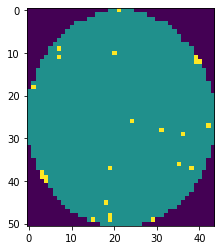

In [86]:
import cv2
img = trainset.waferMap[0]
ret, dst = cv2.threshold(img, 1.9,2.1, cv2.THRESH_BINARY)
plt.imshow(img)

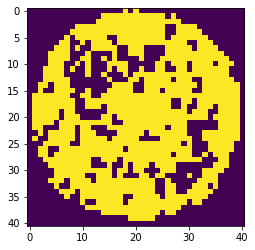

In [87]:
import cv2
img = train_dataloader[-1]
ret, dst = cv2.threshold(img, 1.9,2.1, cv2.THRESH_BINARY)
plt.imshow(img)

In [126]:
pd.DataFrame(train_label).value_counts()

Normal      7000
Nearfull    6968
EdgeRing    6776
Scratch     6680
Random      6666
Donut       6613
Center      6012
Loc         5030
EdgeLoc     3632
dtype: int64

In [118]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
onehot_encoder = preprocessing.OneHotEncoder()
train_y = label_encoder.fit_transform(train_label)
train_y_reshape = train_y.reshape(-1,1)
train_y_onehot = onehot_encoder.fit_transform(train_y_reshape)
train_y_onehot_ary = train_y_onehot.toarray()
train_label = train_y_onehot_ary

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [119]:
train_label

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [120]:
from sklearn.model_selection import train_test_split
TrainData, ValidData, TrainLabel, ValidLabel = train_test_split(train_dataloader, train_label, test_size = 0.3, shuffle = True, stratify =train_label ,random_state = 34)
TrainData = TrainData.reshape(TrainData.shape[0],TrainData.shape[1], TrainData.shape[2],1)
ValidData = ValidData.reshape(ValidData.shape[0],ValidData.shape[1], ValidData.shape[2],1)

print(TrainData.shape, ValidData.shape, TrainLabel.shape, ValidLabel.shape)


(38763, 41, 41, 1) (16614, 41, 41, 1) (38763, 9) (16614, 9)


In [121]:
Epoch = 100
Best_Kernel_S   = 3
Best_Dense_N    = 256
Best_Learning_R = 0.005
Best_Active_function = 'relu'
Best_Channel_C  = [128,256,512]


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  # 모니터 기준 설정 (val loss) 
                              patience=5,         #5 Epoch동안 개선되지 않는다면 종료
                             )


# 학습의 안정을 위해 러닝레이트를 줄이는 방식 선택
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
)

In [122]:
TrainData.shape[1],TrainData.shape[2]

(41, 41)

In [123]:
Best_model = keras.Sequential()

Best_model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./2))
# Convolution layer 1
Best_model.add(keras.layers.Conv2D(Best_Channel_C[0], kernel_size = Best_Kernel_S,activation = Best_Active_function, strides=1,
                              padding='same',
                              input_shape=(TrainData.shape[1],TrainData.shape[2], TrainData.shape[3])))


Best_model.add(keras.layers.BatchNormalization())



# Pooling layer 1
Best_model.add(keras.layers.MaxPooling2D(pool_size=2, strides=1, padding='same'))

# Convolution layer 2
Best_model.add(keras.layers.Conv2D(Best_Channel_C[1],  kernel_size = Best_Kernel_S, activation = Best_Active_function, strides=1,
                              padding='same'))

Best_model.add(keras.layers.BatchNormalization())



# Pooling layer 2
Best_model.add(keras.layers.MaxPooling2D(pool_size=2, strides=1, padding='same'))

# Convolution layer 3
Best_model.add(keras.layers.Conv2D(Best_Channel_C[2], kernel_size = Best_Kernel_S, activation = Best_Active_function, strides=1,
                              padding='same'))

Best_model.add(keras.layers.BatchNormalization())


# Pooling layer 3
Best_model.add(keras.layers.MaxPooling2D(pool_size=2, strides=1, padding='same')) 

#Flattening Layer
Best_model.add((keras.layers.GlobalAveragePooling2D()))

Best_model.add(keras.layers.Dense(units = Best_Dense_N, activation = 'sigmoid'))

Best_model.add(keras.layers.Dropout(0.5))

Best_model.add(keras.layers.Dense(units = Best_Dense_N/2, activation = 'sigmoid'))

Best_model.add(keras.layers.Dropout(0.5))


# Output Layer 확인 필요
Best_model.add(keras.layers.Dense(units = len(newLabel_list), activation = 'sigmoid'))

# weight 초기 세팅 추가해야함

Best_model.compile(optimizer= keras.optimizers.Adam(learning_rate = Best_Learning_R),
            loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
# Best_model.summary()

In [105]:
Best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 41, 41, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 41, 41, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 41, 41, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 41, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 41, 256)       295168    
                                                                 
 batch_normalization_1 (Batc  (None, 41, 41, 256)      1

In [108]:
Best_model.predict(TestData[0]).shape

(41, 9)

In [116]:
TrainLabel

array([['Random'],
       ['Nearfull'],
       ['Random'],
       ...,
       ['Donut'],
       ['Nearfull'],
       ['EdgeRing']], dtype='<U8')

In [134]:
Epoch = 20
with tf.device(device_name):
  Best_model.fit(TrainData,
        TrainLabel,
        validation_data =(ValidData, ValidLabel),
        epochs=Epoch,
        # callbacks = [reduceLR, earlystopping],
        verbose=2,
        batch_size=128)


Epoch 1/20
303/303 - 204s - loss: 0.4366 - accuracy: 0.8404 - val_loss: 0.5346 - val_accuracy: 0.8094 - 204s/epoch - 673ms/step
Epoch 2/20
303/303 - 203s - loss: 0.4130 - accuracy: 0.8483 - val_loss: 0.5839 - val_accuracy: 0.7918 - 203s/epoch - 670ms/step
Epoch 3/20
303/303 - 203s - loss: 0.4076 - accuracy: 0.8493 - val_loss: 0.5896 - val_accuracy: 0.7929 - 203s/epoch - 670ms/step
Epoch 4/20
303/303 - 203s - loss: 0.3989 - accuracy: 0.8535 - val_loss: 0.5760 - val_accuracy: 0.8011 - 203s/epoch - 670ms/step
Epoch 5/20
303/303 - 204s - loss: 0.3830 - accuracy: 0.8584 - val_loss: 0.5530 - val_accuracy: 0.8081 - 204s/epoch - 674ms/step
Epoch 6/20
303/303 - 205s - loss: 0.3748 - accuracy: 0.8615 - val_loss: 0.5739 - val_accuracy: 0.8025 - 205s/epoch - 676ms/step
Epoch 7/20
303/303 - 205s - loss: 0.3694 - accuracy: 0.8639 - val_loss: 0.6137 - val_accuracy: 0.7967 - 205s/epoch - 676ms/step
Epoch 8/20
303/303 - 205s - loss: 0.3537 - accuracy: 0.8688 - val_loss: 0.6322 - val_accuracy: 0.7939 - 

In [156]:
testset.Label

0           Center
1           Normal
2           Center
3           Normal
4        Edge-Ring
           ...    
10651       Normal
10652     Edge-Loc
10653       Center
10654        Donut
10655    Edge-Ring
Name: Label, Length: 10656, dtype: object

In [161]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
onehot_encoder = preprocessing.OneHotEncoder()
test_y = testset.Label
test_y = label_encoder.fit_transform(test_y)
test_y_reshape = test_y.reshape(-1,1)
test_y_onehot = onehot_encoder.fit_transform(test_y_reshape)
test_y_onehot = test_y_onehot.toarray()
test_y_onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [169]:
testset.Label.value_counts()

Normal       3000
Edge-Ring    2904
Edge-Loc     1557
Center       1288
Loc          1078
Scratch       358
Random        260
Donut         166
Near-full      45
Name: Label, dtype: int64

In [168]:
pd.DataFrame(test_y_reshape).value_counts()

6    3000
3    2904
2    1557
0    1288
4    1078
8     358
7     260
1     166
5      45
dtype: int64

In [130]:
testset_img = testset.waferMap
test_img = []

for idx in tqdm(range(testset_img.shape[0])):
  img = testset_img[idx]
  img = cv2.resize(temp_img, dsize = (weightAvg, weightAvg), interpolation = cv2.INTER_LINEAR)
  ret, binary_img = cv2.threshold(img, 1.9,2.1, cv2.THRESH_BINARY)
  test_img.append(binary_img)

test_img = np.array(test_img)
print(testset.waferMap.shape)
print(test_img.shape)

100%|██████████| 10656/10656 [00:00<00:00, 49837.82it/s]

(10656,)
(10656, 41, 41)


In [153]:
test_y_onehot = test_y_onehot.reshape(-1,1)
test_img = test_img.reshape(test_img.shape[0], test_img.shape[1], test_img.shape[2], 1)
TestData = test_img
TestLabel = test_y_onehot

In [135]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

# tn, fp, fn, tp = confusion_matrix(TestLabel,Best_model.predict(TestData)).ravel()
# print(tn, fp, fn, tp)

# plot = plot_confusion_matrix(Best_model, # 분류 모델
#                              TestData, TestLabel, # 예측 데이터와 예측값의 정답(y_true)
#                              display_labels=label, # 표에 표시할 labels
#                              cmap=plt.cm.Blue, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
#                              normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
# plot.ax_.set_title('Confusion Matrix')
# label = ['정상', '고장']
plot = plot_confusion_matrix(Best_model, TestData, TestLabel) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


ValueError: ignored

In [154]:
TestLabel

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

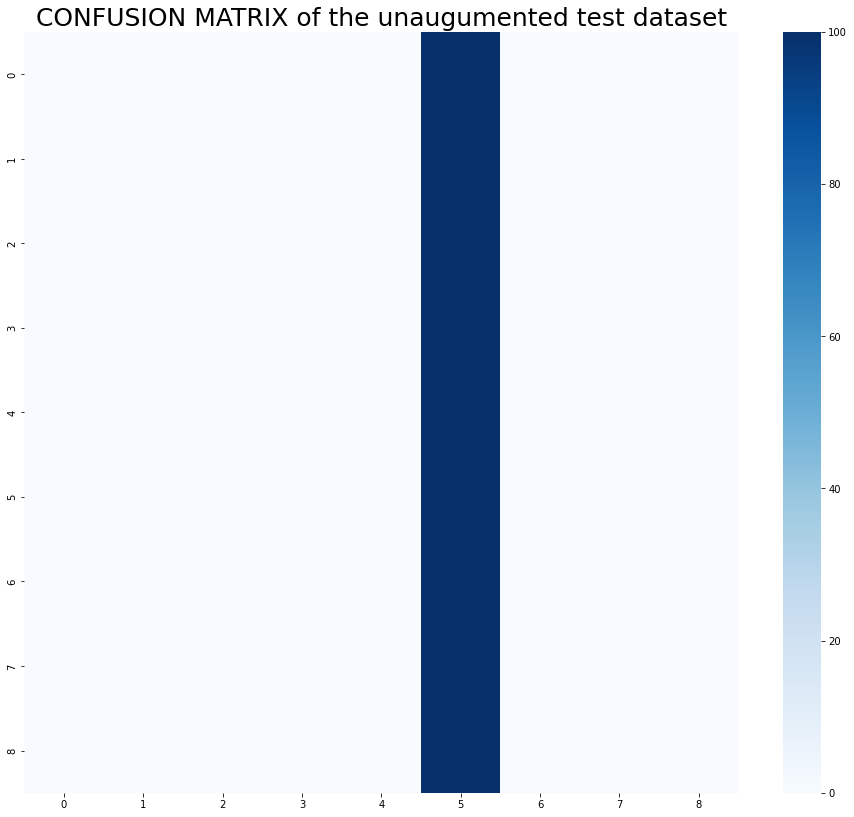

In [163]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = onehot_list
y_pred = y_array
plt.figure(figsize=(16,14))
sns.heatmap(confusion_matrix(y_true, 
                             y_pred, 
                             normalize = 'true')*100, 
            cmap='Blues')
plt.title("CONFUSION MATRIX of the unaugumented test dataset", fontsize=25) # 여전히 none에만 집중하는 형태 확인
plt.show()
# f1score_ = f1_score(encoder.inverse_transform(y_true), encoder.inverse_transform(y_pred), labels=faulty_case, average='micro')
# print('f1score:' ,round(f1score_*100,3))

In [145]:
y_pred.shape[0]

10656

In [146]:
y_pred[0]

array([3.0741514e-05, 3.4103850e-05, 7.6964386e-02, 1.4910706e-03,
       1.2959018e-02, 9.9991155e-01, 4.0190504e-03, 1.4964696e-02,
       5.0887455e-05], dtype=float32)

In [147]:
y_list = []
for idx in range(y_pred.shape[0]):
  value = np.argmax(y_pred[idx])
  y_list.append(value)
y_array = np.array(y_list)
y_array.shape

(10656,)

In [150]:
y_true.

(95904, 1)

In [162]:
test_y_onehot

onehot_list = []
for idx in range(test_y_onehot.shape[0]):
  value = np.argmax(test_y_onehot[idx])
  onehot_list.append(value)
onehot_list = np.array(onehot_list)
onehot_list.shape

(10656,)

In [165]:
pd.DataFrame(y_array).value_counts()

5    10656
dtype: int64

In [166]:
pd.DataFrame(onehot_list).value_counts()

6    3000
3    2904
2    1557
0    1288
4    1078
8     358
7     260
1     166
5      45
dtype: int64